In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Cell 2: Unzip Data from Drive to Local Colab Environment
import os

print("--- Step 1: Unzipping Dataset from Google Drive ---")

# --- USER: UPDATE THIS PATH ---
DRIVE_ZIP_PATH = '/content/drive/My Drive/DeepFakeDataset/140k-real-and-fake-faces.zip'
LOCAL_DATA_PATH = '/content/dataset'

# Clean up any old data and unzip the file to the fast local disk
if not os.path.exists(os.path.join(LOCAL_DATA_PATH, 'real_vs_fake')):
    print("Unzipping... this may take a minute.")
    !rm -rf "{LOCAL_DATA_PATH}"
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)
    !unzip -q "{DRIVE_ZIP_PATH}" -d "{LOCAL_DATA_PATH}"
else:
    print("Dataset already unzipped.")


print("✅ Data ready for training.\n")

--- Step 1: Unzipping Dataset from Google Drive ---
Unzipping... this may take a minute.
✅ Data ready for training.



In [ ]:
# Cell 3: Define the ImageDataset Class
import torch
from torch.utils.data import Dataset
import cv2

class ImageDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        # CrossEntropyLoss requires labels as LongTensor
        return img, torch.tensor(label, dtype=torch.long)

print("ImageDataset class defined.")

ImageDataset class defined.


In [ ]:
# Cell 4: Define the ResNeXt50 Model Architecture
import torch.nn as nn
import torchvision.models as models

def create_resnext50_model(num_classes=2):
    # Load a pre-trained ResNeXt50 model
    model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V1)

    # Freeze all the parameters in the pre-trained model
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of input features for the final fully connected layer
    num_ftrs = model.fc.in_features

    # Replace the final layer with a new one for our binary classification task
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

print("ResNeXt50 model function defined.")


ResNeXt50 model function defined.


In [ ]:
# Cell 5: Create the Data Loaders
import glob
from torchvision import transforms
from torch.utils.data import DataLoader

print("\n--- Step 2: Preparing Data Loaders ---")
DATA_DIR = '/content/dataset/real_vs_fake/real-vs-fake'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'valid')

train_real_files = glob.glob(os.path.join(TRAIN_DIR, 'real', '*.jpg'))
train_fake_files = glob.glob(os.path.join(TRAIN_DIR, 'fake', '*.jpg'))
train_list = [(path, 0) for path in train_fake_files] + [(path, 1) for path in train_real_files]

valid_real_files = glob.glob(os.path.join(VALID_DIR, 'real', '*.jpg'))
valid_fake_files = glob.glob(os.path.join(VALID_DIR, 'fake', '*.jpg'))
valid_list = [(path, 0) for path in valid_fake_files] + [(path, 1) for path in valid_real_files]

print(f"Found {len(train_list)} training images.")
print(f"Found {len(valid_list)} validation images.")

im_size = 224
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_data = ImageDataset(train_list, transform=data_transforms)
valid_data = ImageDataset(valid_list, transform=data_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2)

print("✅ Data loaders are ready.\n")


--- Step 2: Preparing Data Loaders ---
Found 100000 training images.
Found 20000 validation images.
✅ Data loaders are ready.



In [ ]:
# Cell 6: Train the Model with Checkpointing
import torch.optim as optim
from tqdm import tqdm

print("--- Step 3: Setting Up for Training ---")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Define the save directory ---
MODEL_DIR = '/content/drive/My Drive/DeepFakeDataset/Old_Models'

# --- NEW: Define model paths with 'resnext50' name ---
BEST_MODEL_PATH = os.path.join(MODEL_DIR, 'resnext50_32x4d_best_model.pth')
CHECKPOINT_PATH = os.path.join(MODEL_DIR, 'resnext50_32x4d_checkpoint.pth')

# Ensure the directory exists
os.makedirs(MODEL_DIR, exist_ok=True)
print(f"Models and checkpoints will be saved in: {MODEL_DIR}")


# Initialize model and optimizer
model = create_resnext50_model().to(device) # <-- Use ResNeXt50
lr = 1e-4
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# --- Load checkpoint if it exists ---
start_epoch = 0
best_valid_acc = 0.0

if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_valid_acc = checkpoint.get('best_valid_acc', 0.0)
    print(f"✅ Checkpoint found. Resuming training from epoch {start_epoch}")
else:
    print("ℹ️ No checkpoint found. Starting training from scratch.")

print(f"Training for {num_epochs} total epochs on device: {device}\n")

# --- Training loop ---
for epoch in range(start_epoch, num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_corrects.double() / len(train_loader.dataset)

    # --- Validation Phase ---
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    valid_loss = running_loss / len(valid_loader.dataset)
    valid_acc = running_corrects.double() / len(valid_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Valid Loss: {valid_loss:.4f} Acc: {valid_acc:.4f}")

    # --- Save the best model based on validation accuracy ---
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"🎉 New best model saved with accuracy: {best_valid_acc:.4f}")

    # --- Save checkpoint after every epoch ---
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_valid_acc': best_valid_acc
    }
    torch.save(checkpoint_data, CHECKPOINT_PATH)
    print(f"💾 Checkpoint saved for epoch {epoch+1}.\n")


print("--- TRAINING COMPLETE ---")

--- Step 3: Setting Up for Training ---
Models and checkpoints will be saved in: /content/drive/My Drive/DeepFakeDataset/Old_Models
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


100%|██████████| 95.8M/95.8M [00:01<00:00, 66.0MB/s]


ℹ️ No checkpoint found. Starting training from scratch.
Training for 10 total epochs on device: cuda



Epoch 1/10 [Valid]: 100%|██████████| 625/625 [01:58<00:00,  5.29it/s]


Epoch 1/10 | Train Loss: 0.4883 Acc: 0.7710 | Valid Loss: 0.4332 Acc: 0.8004
🎉 New best model saved with accuracy: 0.8004
💾 Checkpoint saved for epoch 1.



Epoch 2/10 [Valid]: 100%|██████████| 625/625 [01:57<00:00,  5.34it/s]


Epoch 2/10 | Train Loss: 0.4258 Acc: 0.8076 | Valid Loss: 0.4031 Acc: 0.8205
🎉 New best model saved with accuracy: 0.8205
💾 Checkpoint saved for epoch 2.



Epoch 3/10 [Valid]: 100%|██████████| 625/625 [01:55<00:00,  5.40it/s]


Epoch 3/10 | Train Loss: 0.4090 Acc: 0.8165 | Valid Loss: 0.3919 Acc: 0.8239
🎉 New best model saved with accuracy: 0.8239
💾 Checkpoint saved for epoch 3.



Epoch 4/10 [Valid]: 100%|██████████| 625/625 [01:56<00:00,  5.38it/s]


Epoch 4/10 | Train Loss: 0.3990 Acc: 0.8217 | Valid Loss: 0.3816 Acc: 0.8300
🎉 New best model saved with accuracy: 0.8300
💾 Checkpoint saved for epoch 4.



Epoch 5/10 [Valid]: 100%|██████████| 625/625 [01:56<00:00,  5.38it/s]


Epoch 5/10 | Train Loss: 0.3912 Acc: 0.8259 | Valid Loss: 0.3746 Acc: 0.8330
🎉 New best model saved with accuracy: 0.8330
💾 Checkpoint saved for epoch 5.



Epoch 6/10 [Valid]: 100%|██████████| 625/625 [01:56<00:00,  5.35it/s]


Epoch 6/10 | Train Loss: 0.3861 Acc: 0.8280 | Valid Loss: 0.3704 Acc: 0.8363
🎉 New best model saved with accuracy: 0.8363
💾 Checkpoint saved for epoch 6.



Epoch 7/10 [Valid]: 100%|██████████| 625/625 [01:56<00:00,  5.39it/s]


Epoch 7/10 | Train Loss: 0.3801 Acc: 0.8322 | Valid Loss: 0.3640 Acc: 0.8401
🎉 New best model saved with accuracy: 0.8401
💾 Checkpoint saved for epoch 7.



Epoch 8/10 [Valid]: 100%|██████████| 625/625 [01:56<00:00,  5.39it/s]


Epoch 8/10 | Train Loss: 0.3765 Acc: 0.8343 | Valid Loss: 0.3610 Acc: 0.8417
🎉 New best model saved with accuracy: 0.8417
💾 Checkpoint saved for epoch 8.



Epoch 9/10 [Valid]: 100%|██████████| 625/625 [01:55<00:00,  5.41it/s]


Epoch 9/10 | Train Loss: 0.3742 Acc: 0.8343 | Valid Loss: 0.3587 Acc: 0.8431
🎉 New best model saved with accuracy: 0.8431
💾 Checkpoint saved for epoch 9.



Epoch 10/10 [Valid]: 100%|██████████| 625/625 [01:55<00:00,  5.40it/s]


Epoch 10/10 | Train Loss: 0.3701 Acc: 0.8373 | Valid Loss: 0.3568 Acc: 0.8438
🎉 New best model saved with accuracy: 0.8438
💾 Checkpoint saved for epoch 10.

--- TRAINING COMPLETE ---


In [ ]:
# Cell 7: Load Best Model for Evaluation
print("\n--- Step 4: Evaluating the Best Model ---")
# Instantiate a new ResNeXt50 model and load the best saved weights
model = create_resnext50_model().to(device)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
print("✅ Best ResNeXt50 model weights loaded for evaluation.")


--- Step 4: Evaluating the Best Model ---
✅ Best ResNeXt50 model weights loaded for evaluation.


In [ ]:
# Cell 8: Get Predictions and True Labels
from tqdm import tqdm

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(valid_loader, desc="Generating predictions on validation set"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("✅ Predictions generated.")

Generating predictions on validation set: 100%|██████████| 625/625 [01:56<00:00,  5.39it/s]

✅ Predictions generated.


In [ ]:
# Cell 9: Calculate and Show Classification Report
from sklearn.metrics import classification_report

class_names = ['FAKE', 'REAL'] # 0 = FAKE, 1 = REAL
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))


--- Classification Report ---
              precision    recall  f1-score   support

        FAKE       0.86      0.82      0.84     10000
        REAL       0.83      0.86      0.85     10000

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000




--- Confusion Matrix ---


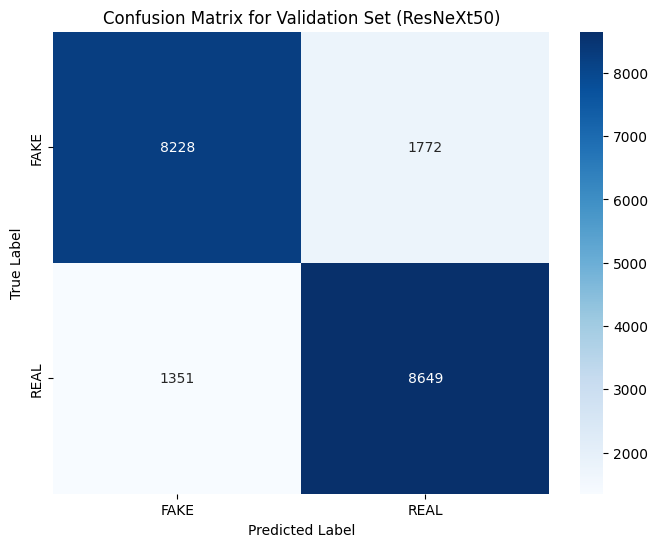

In [ ]:
# Cell 10: Calculate and Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set (ResNeXt50)')
plt.show()